In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
url = 'http://ufldl.stanford.edu/housenumbers/'
train_filename = 'train.tar.gz'
test_filename = 'test.tar.gz'

last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        last_percent_reported = percent

def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

maybe_download(train_filename, 404141560)
maybe_download(test_filename, 276555967)

Found and verified train.tar.gz
Found and verified test.tar.gz


'test.tar.gz'

In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
  
maybe_extract(train_filename)
maybe_extract(test_filename)

train already present - Skipping extraction of train.tar.gz.
test already present - Skipping extraction of test.tar.gz.


In [5]:
import json

def load_file_meta(filename):
    results = []
    with open(filename) as data_file:    
        data = json.load(data_file)
    
    for file_info in data:
        pic_info = {}
        pic_info['boxes'] = [{a : item[a] for a in ['top', 'left', 'height', 'width']}
                             for item in file_info['boxes']]
        pic_info['label'] = np.array([int(item['label']) % 10 for item in file_info['boxes']])
        pic_info['filename'] = file_info['filename']
        results.append(pic_info)
    return results
    
train_info = load_file_meta('train/digitStruct.json')
test_info = load_file_meta('test/digitStruct.json')

print("\n".join([str(a) for a in train_info[:5]]))
    
img_width = 160
img_height = 90    

{'boxes': [{'width': 81.0, 'top': 77.0, 'height': 219.0, 'left': 246.0}, {'width': 96.0, 'top': 81.0, 'height': 219.0, 'left': 323.0}], 'filename': u'1.png', 'label': array([1, 9])}
{'boxes': [{'width': 23.0, 'top': 29.0, 'height': 32.0, 'left': 77.0}, {'width': 26.0, 'top': 25.0, 'height': 32.0, 'left': 98.0}], 'filename': u'2.png', 'label': array([2, 3])}
{'boxes': [{'width': 8.0, 'top': 5.0, 'height': 15.0, 'left': 17.0}, {'width': 9.0, 'top': 5.0, 'height': 15.0, 'left': 25.0}], 'filename': u'3.png', 'label': array([2, 5])}
{'boxes': [{'width': 15.0, 'top': 13.0, 'height': 34.0, 'left': 57.0}, {'width': 13.0, 'top': 13.0, 'height': 34.0, 'left': 72.0}], 'filename': u'4.png', 'label': array([9, 3])}
{'boxes': [{'width': 21.0, 'top': 7.0, 'height': 46.0, 'left': 52.0}, {'width': 15.0, 'top': 10.0, 'height': 46.0, 'left': 74.0}], 'filename': u'5.png', 'label': array([3, 1])}


************************************************************
Original (32, 70)


/home/brad/anaconda/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:573: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


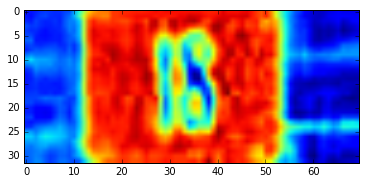

Zoomed (90, 197)


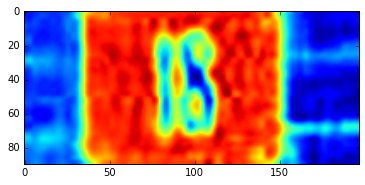

Cropped (90, 160)
Center 91.40625 45.0


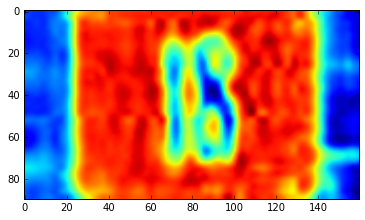

Filename:3618.png
Label:[1 8]
Color range: 0.5 -0.5
************************************************************
Original (49, 141)


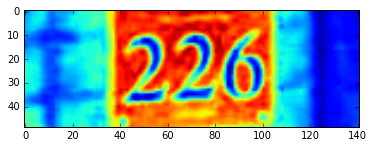

Zoomed (90, 259)


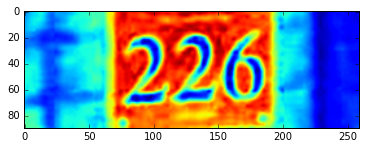

Cropped (90, 160)
Center 127.959183673 42.2448979592


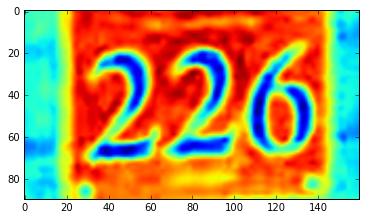

Filename:6643.png
Label:[2 2 6]
Color range: 0.5 -0.5
************************************************************
Original (55, 127)


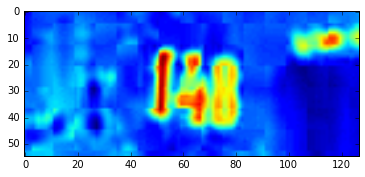

Zoomed (90, 208)


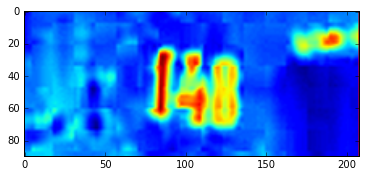

Cropped (90, 160)
Center 108.0 41.4545454545


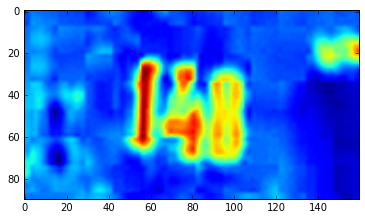

Filename:22862.png
Label:[1 4 8]
Color range: 0.5 -0.5


In [6]:
pixel_depth = 255.0  # Number of levels per pixel.
import os
from scipy import ndimage
import scipy.misc as spm
import scipy.ndimage as spn

screen_ratio = 1080./1920.

def pre_process_file(folder, pic_info, show=False):
    image_file = os.path.join(folder, pic_info['filename'])

    image_data = (ndimage.imread(image_file, flatten=True).astype(float) - 
                pixel_depth / 2) / pixel_depth

    ratio = 1.0 * image_data.shape[0] / image_data.shape[1]

    if ratio < screen_ratio:
        factor = 1.0 * img_height / image_data.shape[0]
    else:
        factor = 1.0 * img_width / image_data.shape[1]

    img = spn.interpolation.zoom(image_data, factor)

    # Center the picture around the bounding boxes as much as possible
    center_x = np.mean([box['left'] + (box['width'] // 2) for box in pic_info['boxes']]) * factor
    center_y = np.mean([box['top'] + (box['height'] // 2) for box in pic_info['boxes']]) * factor

    # The start x pos for copying the image
    s_x = int(center_x) - img_width // 2        
    if s_x < 0:
        s_x = 0
    elif s_x + img_width > img.shape[1]:
        s_x = img.shape[1] - img_width

    s_y = int(center_y) - img_height
    if s_y < 0:
        s_y = 0
    elif s_y + img_height > img.shape[0]:
        s_y = img.shape[0] - img_height

    img_resized = img[s_y:s_y + img_height, s_x:s_x+img_width].astype(np.float32)

    img_colors = img_resized.astype(np.float32) - np.min(img_resized)
    img_colors = img_colors / np.max(img_colors) - 0.5

    if show:
        print('*' * 60)
        print("Original", image_data.shape)
        plt.imshow(image_data)
        plt.show()
        print("Zoomed", img.shape)
        plt.imshow(img)
        plt.show()
        print("Cropped", img_resized.shape)
        print("Center", center_x, center_y)
        plt.imshow(img_resized)
        plt.show()
        print("Filename:%s" % pic_info['filename'])
        print("Label:%s" % pic_info['label'])
        print("Color range:", np.max(img_colors), np.min(img_colors))

    return img_colors, pic_info['label']

np.random.shuffle(train_info)
tmp_img, tmp_label = pre_process_file('train', np.random.choice(train_info, 1)[0], show=True)
tmp_img, tmp_label = pre_process_file('train', np.random.choice(train_info, 1)[0], show=True)
tmp_img, tmp_label = pre_process_file('train', np.random.choice(train_info, 1)[0], show=True)

[6 2]


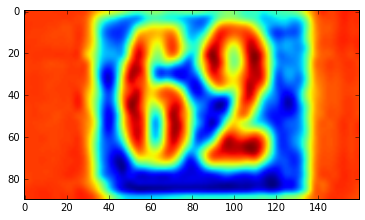

[1 4 9]


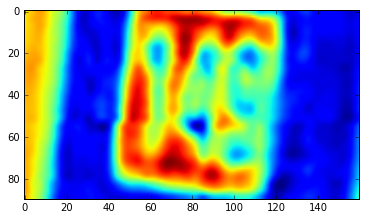

[6 0]


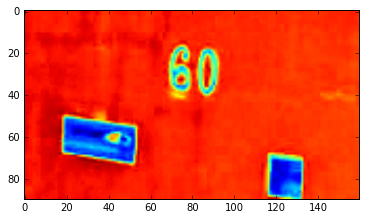

[2 3]


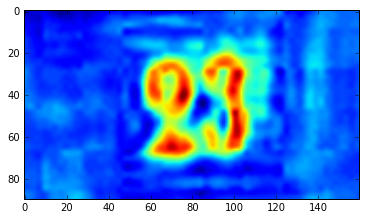

[1 9]


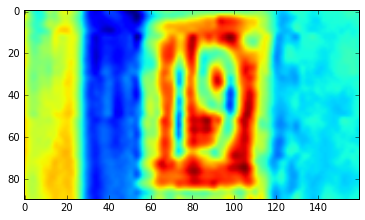

[2 6]


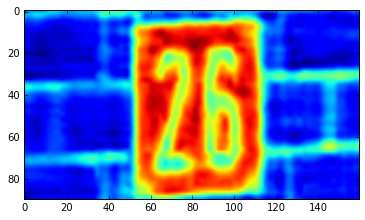

[1 9]


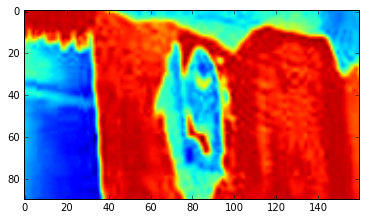

[4]


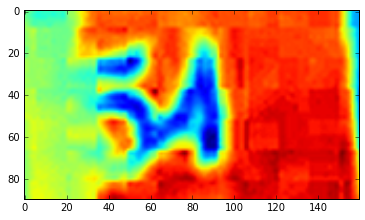

[9]


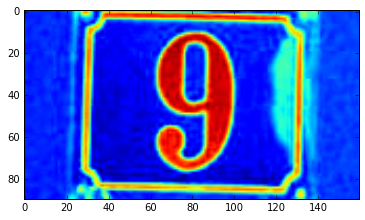

[5 6]


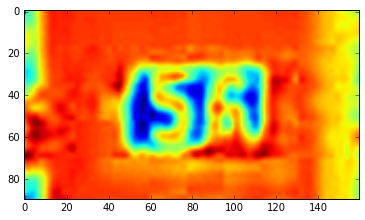

In [7]:
from multiprocessing import Pool
from functools import partial


def pre_process_img_map(args):
    return pre_process_file(**args)


def generate_batch_parallel(folder, pic_info_list, show=False):
    """Load the data for a single letter label."""
    global started
    global finished
    started = 0
    finished = 0
    pool = Pool()    
    results = pool.map(partial(pre_process_file, 'train'), pic_info_list)
    pool.close()
    pool.join()
    
    imgs, labels = zip(*results)
    return np.array(imgs), np.array(labels)
    

np.random.shuffle(train_info)
tmp_pics, tmp_labels = generate_batch_parallel('train', train_info[:10])

for i, tmp_label in enumerate(tmp_labels):
    print(tmp_label)
    plt.imshow(tmp_pics[i])
    plt.show()

In [8]:
%reset_selective -f tmp_.*

In [9]:
no_train_pics = 20000
no_valid_pics = 2000
no_test_pics = 6000

np.random.shuffle(train_info)

start =  0
end = start + no_train_pics
train_dataset, train_labels = generate_batch_parallel('train', train_info[start:end])
print("Done training")
start = end
end = start + no_valid_pics
valid_dataset, valid_labels = generate_batch_parallel('train', train_info[start:end])
print("Done validation")
start = end
end = start + no_test_pics
test_dataset, test_labels = generate_batch_parallel('train', train_info[start:end])
print("Done test")

pickle_file = 'SVHN.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
statinfo = os.stat(pickle_file)
print('Compressed pickle size:%dmb' % (statinfo.st_size // 1024**2))

Done training
Done validation
Done test
Compressed pickle size:1539mb
